cluster
2    64357
3    45775
1    26791
0    21984
4    14034
Name: count, dtype: int64


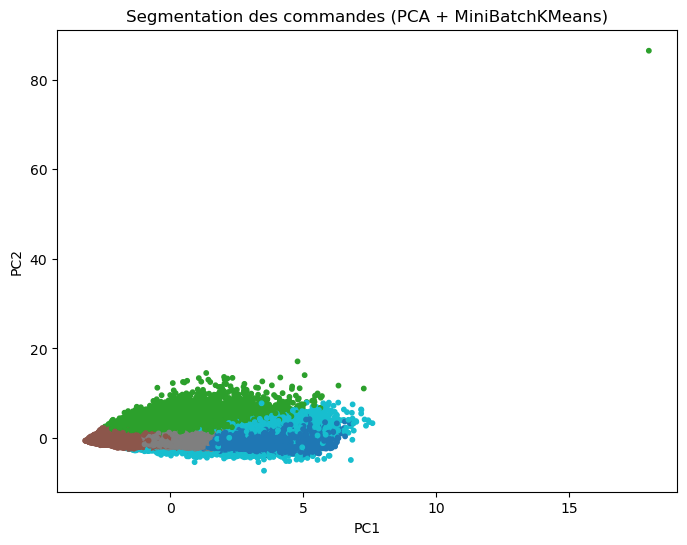

In [7]:
# ===============================
# BO2 : Clustering optimisé
# ===============================
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Charger données
df = pd.read_csv("datadelevry.csv")

# Sélection de features
features = ["market_id", "store_primary_category", "order_protocol",
            "total_items", "subtotal", "num_distinct_items",
            "min_item_price", "max_item_price",
            "total_onshift_partners", "total_busy_partners", "total_outstanding_orders"]

X = df[features].copy()

# ===============================
# Encodage catégoriel (frequency encoding)
# ===============================
for col in ["market_id", "store_primary_category", "order_protocol"]:
    freqs = X[col].value_counts(normalize=True)  # fréquence relative
    X[col] = X[col].map(freqs)

# ===============================
# Prétraitement numérique
# ===============================
num_features = ["total_items", "subtotal", "num_distinct_items",
                "min_item_price", "max_item_price",
                "total_onshift_partners", "total_busy_partners", "total_outstanding_orders",
                "market_id", "store_primary_category", "order_protocol"]

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_scaled = scaler.fit_transform(imputer.fit_transform(X[num_features]))

# ===============================
# Clustering avec MiniBatchKMeans
# ===============================
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=1000)
df["cluster"] = kmeans.fit_predict(X_scaled)

print(df["cluster"].value_counts())

# ===============================
# Visualisation PCA (2D)
# ===============================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="tab10", s=10)
plt.title("Segmentation des commandes (PCA + MiniBatchKMeans)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Profils des clusters (moyennes par feature numérique) :
         market_id  order_protocol  total_items     subtotal  \
cluster                                                        
0         2.912650        3.201568     2.948694  2362.815011   
1         2.999388        2.648042     6.735371  4743.883518   
2         3.301948        2.651833     2.198334  1875.795226   
3         2.588713        3.081675     2.449973  1994.564053   
4         2.853667        2.844038     3.860258  5172.415515   

         num_distinct_items  min_item_price  max_item_price  \
cluster                                                       
0                  2.528049      636.118908     1084.075653   
1                  5.086264      384.943618     1203.300676   
2                  1.940423      737.966539     1048.368170   
3                  2.141899      659.854466     1027.478251   
4                  3.386799     1166.773564     2116.954497   

         total_onshift_partners  total_busy_partners 

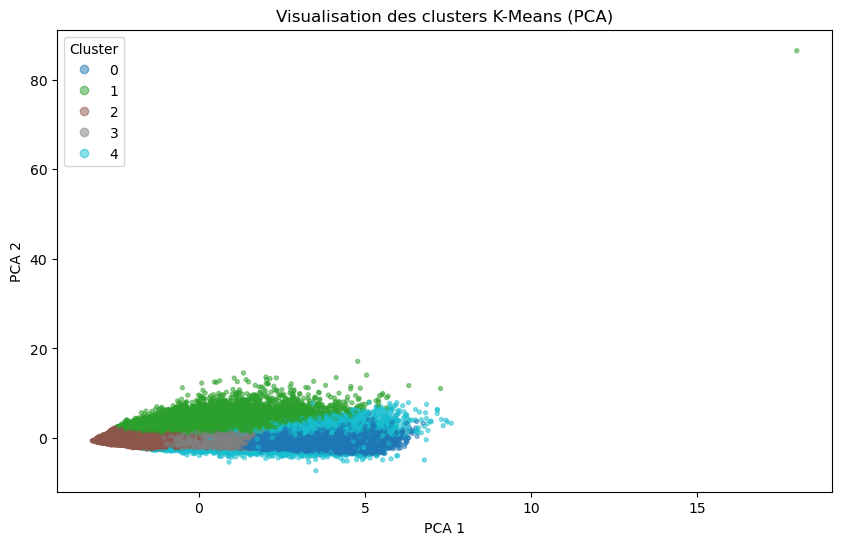

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ===============================
# 1. Profils des clusters
# ===============================
# On ne prend que les features numériques
numeric_features = df[features].select_dtypes(include="number").columns.tolist()

# Moyennes par cluster
cluster_profiles = df.groupby("cluster")[numeric_features].mean()
print("Profils des clusters (moyennes par feature numérique) :")
print(cluster_profiles)

# Taille des clusters
print("\nTaille des clusters :")
print(df["cluster"].value_counts())

# ===============================
# 2. Réduction en 2D (PCA)
# ===============================
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_scaled)  # ⚠️ données normalisées
df["pca1"], df["pca2"] = X_reduced[:, 0], X_reduced[:, 1]

# ===============================
# 3. Visualisation
# ===============================
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["pca1"], df["pca2"],
    c=df["cluster"], cmap="tab10", s=8, alpha=0.5
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualisation des clusters K-Means (PCA)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


In [ ]:
🔎 Analyse des profils de clusters

Cluster 2 (64k commandes, le plus gros groupe)

Petits paniers : ~2 articles, ~1 875 en subtotal.

Prix unitaires élevés (~738 minimum).

Peu de partenaires disponibles (17 en moyenne).
➡️ Commandes simples mais chères, avec peu de logistique.

Cluster 3 (45k commandes)

~2,4 articles, ~1 995 en subtotal.

Niveau de prix similaire à cluster 2 (660–1 027).

Logistique plus dense : ~48 partenaires en moyenne.
➡️ Commandes modestes, prix modéré, zones urbaines plus denses.

Cluster 1 (27k commandes)

Paniers plus gros : ~6,7 articles, subtotal élevé (~4 744).

Prix unitaire moyen plus bas (385 min → achats de masse ?).

Peu de partenaires (28 en moyenne).
➡️ Commandes volumineuses mais zones moins denses.

Cluster 0 (21k commandes)

~3 articles, subtotal ~2 362.

Prix unitaires intermédiaires (~636–1 084).

Forte présence de partenaires (~104 disponibles).
➡️ Commandes standard dans zones bien desservies.

Cluster 4 (14k commandes, le plus petit)

Panier moyen (3,9 articles) mais subtotal très élevé (~5 172).

Prix unitaire très élevé (min ~1 167, max ~2 117).

Logistique dense (~76 partenaires).
➡️ Commandes premium, clients à fort pouvoir d’achat dans zones bien couvertes.

🗂️ Interprétation métier

Cluster 2 & 3 : petits paniers → optimisation via groupage des commandes.

Cluster 1 : paniers volumineux mais zones moins couvertes → besoin d’optimiser la capacité de livraison.

Cluster 0 : zones bien couvertes → on peut jouer sur l’allocation dynamique des livreurs.

Cluster 4 : clients premium → priorité logistique pour maximiser satisfaction.

👉 On peut même attribuer des étiquettes métiers :

Cluster 2 = "Petites commandes isolées"

Cluster 3 = "Commandes urbaines standard"

Cluster 1 = "Gros paniers hors centre"

Cluster 0 = "Commandes standard en zones denses"

Cluster 4 = "Commandes premium"

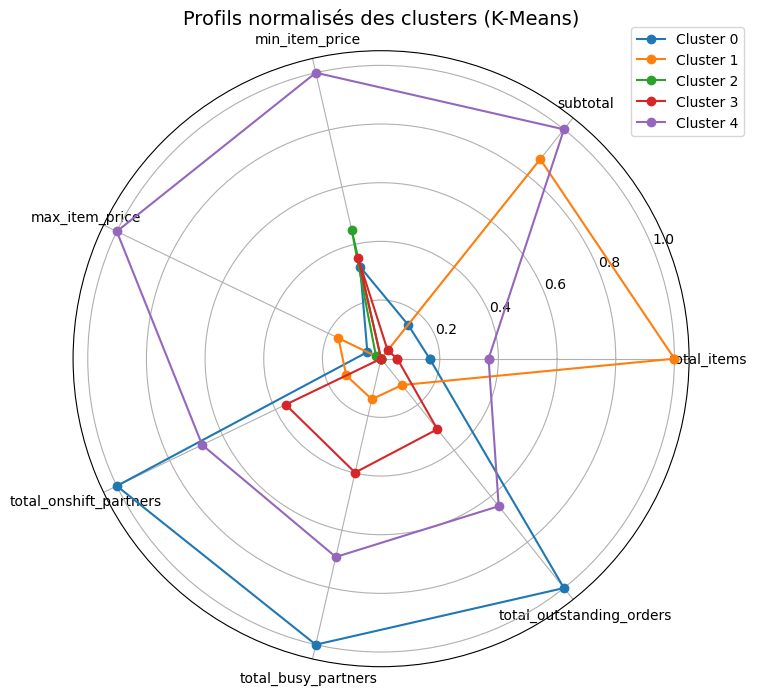

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Reprendre les profils moyens calculés
cluster_profiles = pd.DataFrame({
    "cluster": [0, 1, 2, 3, 4],
    "total_items": [2.95, 6.73, 2.20, 2.45, 3.86],
    "subtotal": [2362.82, 4743.88, 1875.80, 1994.56, 5172.42],
    "min_item_price": [636.12, 384.94, 737.97, 659.85, 1166.77],
    "max_item_price": [1084.08, 1203.30, 1048.37, 1027.48, 2116.95],
    "total_onshift_partners": [103.98, 28.35, 16.87, 48.32, 75.85],
    "total_busy_partners": [95.11, 26.38, 15.02, 46.91, 70.55],
    "total_outstanding_orders": [151.45, 33.32, 17.99, 59.05, 103.82]
}).set_index("cluster")

# Normalisation pour comparer visuellement (min-max scaling)
cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Radar chart setup
labels = cluster_profiles_norm.columns
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * 3.14159 for n in range(num_vars)]
angles += angles[:1]  # fermer le cercle

plt.figure(figsize=(10, 8))

# Tracer chaque cluster
for idx, row in cluster_profiles_norm.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]  # fermer le cercle
    plt.polar(angles, values, marker='o', label=f"Cluster {idx}")

plt.xticks(angles[:-1], labels, fontsize=10)
plt.title("Profils normalisés des clusters (K-Means)", size=14)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


In [ ]:
Chaque cluster a un profil distinct :

Cluster 1 se démarque par beaucoup d’articles par commande et un panier élevé.

Cluster 2 et 3 correspondent à des commandes petites/simples, mais sur des zones différentes (moins de livreurs vs plus disponibles).

Cluster 4 est premium : prix plus élevés, panier conséquent, forte tension logistique.

Cluster 0 combine panier modéré et forte disponibilité de livreurs.